In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

%matplotlib inline

# Setup data location

In [2]:
train_dir = '/datashare/datasets_3rd_party/bdd/bdd100k/images/100k/train'
label_file = '/datashare/datasets_3rd_party/bdd/bdd100k/labels_new/bdd100k_labels_images_train.json'

resize_image = True
image_ext = '.jpg'
new_w = 800
new_h = 288
thickness = 8

# Loading data and select the first image in the label list to visualize

In [3]:
data = json.load(open(label_file))

In [4]:
img_info = data[10]
raw_file = os.path.join(train_dir, img_info['name'])
lane_labels = [l for l in img_info['labels']
               if l['category'] == 'lane' and l['attributes']['laneDirection'] == 'parallel']
print(img_info['name'])

00067cfb-caba8a02.jpg


# Merge consecutive lines into 1 lane

In [5]:
# assuming that double-line is consecutive
angles = []
lanes = [] 

for l in lane_labels:
    vertices = l['poly2d'][0]['vertices']
    x0 = vertices[0][0]
    x1 = vertices[1][0]
    y0 = vertices[0][1]
    y1 = vertices[1][1]
    angle = np.rad2deg(np.arctan2(y1 - y0, x1 - x0))
    angles.append(angle)
    lanes.append(vertices)
print(angles)

# difference between two consecutive angles in this list
angle_diffs = [abs(j-i) for i, j in zip(angles[:-1], angles[1:])]
print(angle_diffs)

# maximum angle difference threshold to be considered a same line
angle_threshold = 4

merge_lanes = []
line_merged = False
# merge lanes based on angle differences
for i,angle_diff in enumerate(angle_diffs):
    if line_merged:
        line_merged = False
        continue
    this_lane = lanes[i]
    if angle_diff < angle_threshold:
        # next line will be merged
        this_lane.extend(lanes[i+1])
        line_merged = True    
    merge_lanes.append(this_lane)
    
merge_lanes

[-9.950626442479946, -10.1590560626895, 6.340191789625425, 5.784738427477069, 30.082352534693033, 26.839191555055145, 164.69386102886628, 164.41369552768978]
[0.2084296202095537, 16.499247852314923, 0.5554533621483566, 24.297614107215963, 3.2431609796378886, 137.85466947381113, 0.28016550117649786]


[[[2.996916, 471.514811],
  [173.821138, 441.54565],
  [0, 468.517895],
  [172.822166, 437.549761]],
 [[581.401738, 423.564152],
  [725.253714, 439.547705],
  [967.004952, 471.514811],
  [1016.953555, 474.511727],
  [575.407905, 420.567236],
  [881.093355, 451.53537],
  [1129.837397, 483.502476],
  [1279.683206, 456.53023]],
 [[590.392486, 469.516867],
  [918.055321, 659.321558],
  [603.379123, 462.524063],
  [1019.950471, 673.307167]],
 [[190.803663, 460.526119],
  [0.998972, 512.472666],
  [189.804691, 455.531258],
  [0, 508.476777]]]

# Load the raw image. 

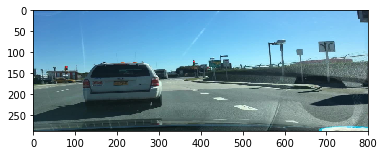

In [6]:
#img = plt.imread(raw_file)
#this will get the same result with plt.imread
img = cv2.imread(raw_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

w = img.shape[1] # 1640
h = img.shape[0] # 590

x_rate = 1.0 * new_w / w
y_rate = 1.0 * new_h / h

if resize_image:
    img = cv2.resize(img, (new_w, new_h))
    
plt.imshow(img)
plt.show()

In [7]:
gt_lanes_org = lanes
gt_lanes_merged = merge_lanes

if resize_image:
    gt_lanes_org = [[(int(x*x_rate), int(y*y_rate)) for (x, y) in lane] for lane in gt_lanes_org] 
    gt_lanes_merged = [[(int(x*x_rate), int(y*y_rate)) for (x, y) in lane] for lane in gt_lanes_merged] 
    

# Draw the ground-truth points

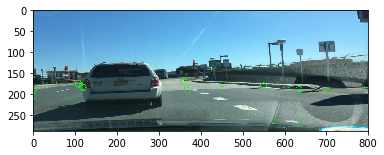

In [8]:
img_vis = img.copy()

for lane in gt_lanes_org:
    for pt in lane:
        cv2.circle(img_vis, pt, radius=thickness, color=(0, 255, 0))

plt.imshow(img_vis)
plt.show()

# Fit the ground truth points with a lines

/home/sang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


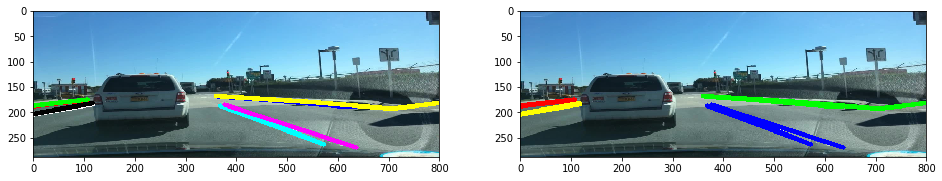

In [12]:
colors = [(255,0,0),(0,255,0),(0,0,255),
         (255,255,0),(0,255,255),(255,0,255),
         (255,255,255),(0,0,0)]

fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 1

# Visualize orginal annotations
img_vis = img.copy()    
for i,lane in enumerate(gt_lanes_org):
    fig.add_subplot(rows, columns, 1)
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=colors[i], thickness=thickness)
    plt.imshow(img_vis)

# Visualize merged annotations (lines belong to a same lane are connected)
img_vis = img.copy()
for i,lane in enumerate(gt_lanes_merged):
    fig.add_subplot(rows, columns, 2)
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=colors[i], thickness=thickness)
    plt.imshow(img_vis)
    
plt.show()

# Generate binary image

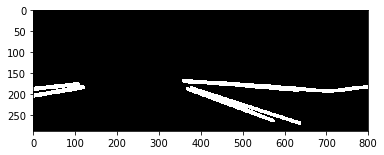

In [10]:
bin_img = np.zeros(shape=[img.shape[0], img.shape[1]], dtype=np.uint8)
nlanes = len(gt_lanes_merged)
for i, lane in enumerate(gt_lanes_merged):
    cv2.polylines(bin_img, np.int32([lane]), isClosed=False, color=1, thickness=thickness)
plt.imshow(bin_img, cmap=plt.cm.gray)
plt.show()    

# Generate lane instance image (different colors for different lanes)

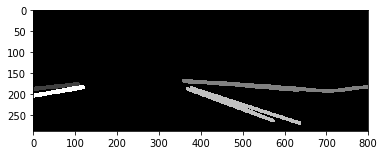

In [11]:
bin_img = np.zeros(shape=[img.shape[0], img.shape[1]], dtype=np.uint8)
nlanes = len(gt_lanes_merged)
color_codes = list(range(0, 255, 255//(nlanes + 1)))[1:]
for i, lane in enumerate(gt_lanes_merged):
    cv2.polylines(bin_img, np.int32([lane]), isClosed=False, color=color_codes[i], thickness=thickness)
plt.imshow(bin_img, cmap=plt.cm.gray)
plt.show()    